Testing the Gaia Challenge simulated data. The stellar profile adopted here reads:
\begin{equation}
\nu_\ast(r) = \rho_h \left(\frac{r}{r_h}\right)^{-\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^{\alpha_\ast}\right)^\frac{\gamma_\ast-\beta_\ast}{\alpha_\ast}
\end{equation}
with parameters values:
* $\alpha_\ast$ = 2
* $\beta_\ast$ = 5
* $r_h$ = 0.1,0.25,1 kpc

leading to the simple expression
\begin{equation}
\nu_\ast(r) = \frac{\rho_h}{\left(\frac{r}{r_h}\right)^{\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^2\right)^{\frac{5-\gamma_\ast}{2}}}
\end{equation}

for $\gamma_\ast = 0.1,1$ this is referred to as "Plummer" and "non-Plummer" stellar profile, respectively.

In the non-Plummer profile case, the surface brightness profile has the following analytic expression:
\begin{equation}
I(R) = 2 \int^\infty_R \frac{\nu_\ast(r) r dr}{\sqrt{r^2-R^2}} = \rho_h \frac{r_h^2\left[(2r_h^2+R^2) csch^{-1}\left(\frac{R}{r_h}\right) - r_h\sqrt{r_h^2+R^2}\right]}{(r_h^2+R^2)^{3/2}}
\end{equation}

As a result, the $line-of-sight$ velocity dispersion $\sigma^2(R)$ that enters the Likelihood has the following expression
\begin{equation}
\sigma^2_{los}(R) = 2G\mu_0\frac{R}{I(R)}\int^\infty_1 \frac{z}{\sqrt{z^2-1}}\int^\infty_{zR}\frac{\nu_\ast(s)\mu(\frac{s}{r_0})}{s^2}dsdz
\end{equation}
Here $\beta$ = 0.
The integral above can be cast into a dimensionless form by performing the following variable transformations: $\gamma = \frac{R}{r_h}$, $y = \frac{s}{r_h}$ and $\alpha = \frac{r_h}{r_0}$.
\begin{equation}
\sigma^2_{los}(R) = 2G\mu_0\frac{\gamma}{I(R)}\int^\infty_1 \frac{z}{\sqrt{z^2-1}}\int^\infty_{z\gamma}\frac{\nu_\ast(y)\mu(y\alpha)}{y^2}dsdz
\end{equation}

In [1]:
import yaml
import numpy as np
from os import mkdir
from sys import argv
from AT import get_data
from scipy import special
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d as interp
from functions_simIS import integral2, Jfactor,nu
from multiprocessing import Pool
%matplotlib inline

In [2]:
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/test/'
casedir = ['Isotrop_Core_nonPlum','Isotrop_Core_Plum','Isotrop_Cusp_nonPlum','Isotrop_Cusp_Plum']

# enter size of Mock dataset (options 100,1000,10000)
MockSize = 1000
# enter model choice - cf. casedir (options 1,2,3,4)
mod = 2

In [3]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r/rh)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] if mod == 2 or mod == 4 else \
rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.)

In [4]:
# Mock data preparation
data = ['/gs100_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_0.dat'%MockSize,      # Isotrop_Core_nonPlum
        '/gs010_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_0.dat'%MockSize,      # Isotrop_Core_Plum
        '/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_0.dat'%MockSize,      # Isotrop_Cusp_nonPlum
        '/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_0.dat'%MockSize]      # Isotrop_Cusp_Plum
err  = ['/gs100_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_0_err.dat'%MockSize,  # Isotrop_Core_nonPlum
        '/gs010_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_0_err.dat'%MockSize,  # Isotrop_Core_Plum
        '/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_0_err.dat'%MockSize,  # Isotrop_Cusp_nonPlum
        '/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_0_err.dat'%MockSize]  # Isotrop_Cusp_Plum
x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir[mod-1]+data[mod-1],unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
D=50.
d = np.sqrt(x**2+y**2+(D-z)**2)
v = (x*vx+y*vy+(D-z)*vz)/d
# Errors (from mock data) preparation
Evx,Evy,Evz = np.loadtxt(homedir+casedir[mod-1]+err[mod-1],unpack=True,usecols=(3,4,5))
Ex,Ey,Ez = np.absolute(Evx-vx),np.absolute(Evy-vy),np.absolute(Evz-vz)
dv = (x*Ex+y*Ey+(D-z)*Ez)/d

In [5]:
u=0.
rh= 1. if mod == 1 or mod == 2 else 0.25

In [6]:
idx = np.arange(10000)
np.random.shuffle(idx)
R,v,dv = R[idx],v[idx],dv[idx]
#np.random.shuffle(R)
#np.random.shuffle(v)
#np.random.shuffle(dv)

R, v, dv = R[:5000], v[:5000], dv[:5000]

In [6]:
gamma_array = R/rh
r0_array = np.logspace(-2,2,200)
alpha_array = rh/r0_array
A_array = np.array([gamma_array[i]/I(Ri,rh) for i,Ri in enumerate(R)])
I_array=np.zeros(shape=(len(A_array),len(r0_array)))

In [7]:
def array_builder(gamma_array, alpha_array):
    for i,gamma in enumerate(gamma_array):
        for j,alpha in enumerate(alpha_array):
            yield (i, j), (gamma, alpha)

def proxy(args):
    return args[0], A_array[args[0][0]]*integral2(*args[1])

In [8]:
pool = Pool(processes=4)
results = pool.map(proxy, array_builder(gamma_array, alpha_array))
pool.close()
pool.join()
for idx,value in results:
    I_array[idx] = value

In [9]:
Jf = np.sqrt([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])

cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
def logLike(J,i):
    I = cst*sqrt(J)*r0_array[i]**3*I_array[:,i]/Jf[i]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

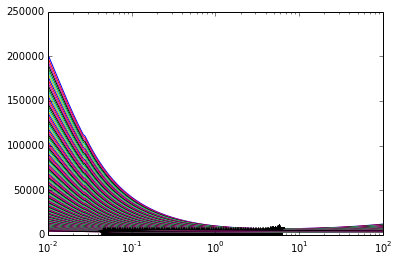

In [28]:
J_array = np.linspace(17,22,200)
J_new = np.empty([0])
min_LikeJ = np.empty([0])
min_r0_arr = np.empty([0])

for J in J_array:                                                  # scan over an array of J values
    LikeJr0 = np.zeros_like(r0_array)
    for i in range(r0_array.size): LikeJr0[i] = logLike(10**J,i) # for each J scan over an array of r0 values
    interp_Like_r0 = interp(r0_array,LikeJr0)                      # build the profile likelihood along ra
        
    eval_Like_r0 = np.logspace(log10(r0_array.min()),log10(r0_array.max()),1e3)
    min_Like_r0 = interp_Like_r0(eval_Like_r0).min()
    min_r0 = eval_Like_r0[np.where(interp_Like_r0(eval_Like_r0)==min_Like_r0)[0]]
    
    if r0_array[1]<min_r0<r0_array[-2]:
        plt.semilogx(r0_array,interp_Like_r0(r0_array),label='J=%.2f'%J)
        plt.plot(min_r0,min_Like_r0,'*',markersize=10,c='k')

        min_r0_arr = np.append(min_r0_arr,min_r0)
        min_LikeJ = np.append(min_LikeJ,min_Like_r0)
        J_new = np.append(J_new,J)

#plt.ylim(310,330)
#plt.xlim(1e-2,1e0)
#plt.legend(bbox_to_anchor=(1.4,1))

min J =  19.54  , r0 =  0.977


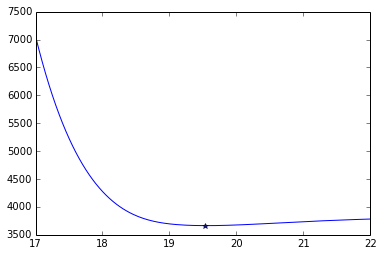

In [29]:
interp_Like = interp(J_new,min_LikeJ)
interp_Like_r0 = interp(J_new,min_r0_arr)
J_min = sciopt.minimize_scalar(interp_Like,method='Bounded',bounds=(J_new[0],J_new[-1])).x
J_r0 = interp_Like_r0(J_min)
print 'min J = ',round(J_min,2),' , r0 = ',round(J_r0,3)
plt.plot(J_new,interp_Like(J_new))
plt.plot(J_min,interp_Like(J_min),'b*')
#plt.ylim(240,260)

In [30]:
def one_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(J_min)-0.5)

one_sigma_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
one_sigma_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

def two_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(J_min)-2.)

two_sigma_l = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
two_sigma_r = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

def three_sigmaJ(J):
    return np.abs(interp_Like(J)-interp_Like(J_min)-4.)

three_sigma_l = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
three_sigma_r = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

In [31]:
print round(J_min,2),round(one_sigma_l,2),round(one_sigma_r,2),round(two_sigma_l,2),\
round(two_sigma_r,2),round(three_sigma_l,2),round(three_sigma_r,2)

19.54 -0.06 0.11 -0.14 0.19 -0.2 0.27


In [32]:
true_rho0 = 4e8 if mod == 1 or mod == 2 else 6.4e7
trueJ = round(np.log10(Jfactor(D,np.inf,1.,true_rho0,0.5)),2)
print 'true J : ',trueJ,', obtained J : ',round(J_min,2)

true J :  19.53 , obtained J :  19.54


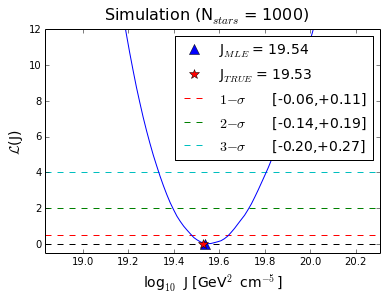

In [33]:
J_plt = np.linspace(J_min+three_sigma_l-0.5,J_min+three_sigma_r+0.5,100)
plt.plot(J_plt,interp_Like(J_plt)-interp_Like(J_min))
plt.plot(J_min,0,'b^',markersize=10,label='J$_{MLE}$ = %.2f'%J_min)
plt.plot(trueJ,0,'r*',markersize=10,label='J$_{TRUE}$ = %.2f'%trueJ)
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%.2f,%+.2f]'%(one_sigma_l,one_sigma_r))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%.2f,%+.2f]'%(two_sigma_l,two_sigma_r))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%.2f,%+.2f]'%(three_sigma_l,three_sigma_r))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.ylabel(r'$\mathcal{L}$(J)',fontsize=14)
plt.xlabel(r'log$_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-0.5,12)
plt.xlim(J_min+three_sigma_l-0.5,J_min+three_sigma_r+0.5)
#plt.savefig(homedir+casedir[mod-1]+'/Sim%i_%s.png'%(R.size,casedir[mod-1]),dpi=300,format='png')
plt.suptitle(r'Simulation (N$_{stars}$ = %i)'%R.size,fontsize=16)
#plt.savefig(homedir+casedir[mod-1]+'/Sim%i_%s_title.png'%(R.size,casedir[mod-1]),dpi=300,format='png')

In [17]:
J_rho0 = sciopt.minimize_scalar(lambda log10rho0:abs(J_min-np.log10(Jfactor(D,np.inf,J_r0,1.,0.5))-2*log10rho0)).x
print '%5s %10s %10s'%('','True','Best fit')
print '%5s %10.2f %10.2f'%('r0',1.,J_r0)
print '%5s %10.2e %10.2e'%('rho0',4e8 if mod == 1 or mod == 2 else 6.4e7,10**J_rho0)

            True   Best fit
   r0       1.00       1.12
 rho0   6.40e+07   5.39e+07


In [50]:
J_rho0 = sciopt.minimize_scalar(lambda log10rho0:abs(min_J-np.log10(Jfactor(D,np.inf,J_r0,1.,0.5))-2*log10rho0)).x
output = open(homedir+casedir+'/results.dat','w')
output.write('%10s %6.1f %10s %6.2f %2s \n'%('True r0   = ',1,'[kpc] \t Best fist r0   = ',J_r0,'[kpc]'))
output.write('%10s %10.2e %10s %10.2e'%('True rho0 = ',4e8,'\t Best fist rho0 = ',10**J_rho0))
output.close()